# Data Mining

In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

--- Analyzing Language: EN ---
Total instances found: 438,913
Total unique markers found: 172


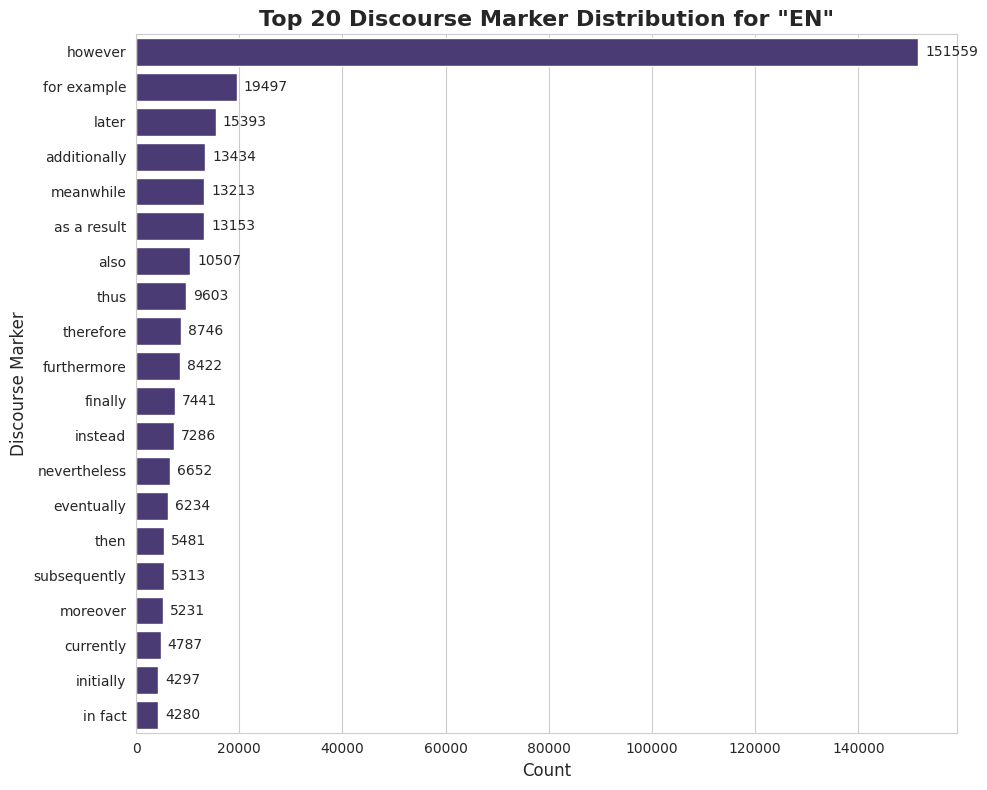

----------------------------------------

--- Analyzing Language: IT ---
Total instances found: 75,973
Total unique markers found: 84


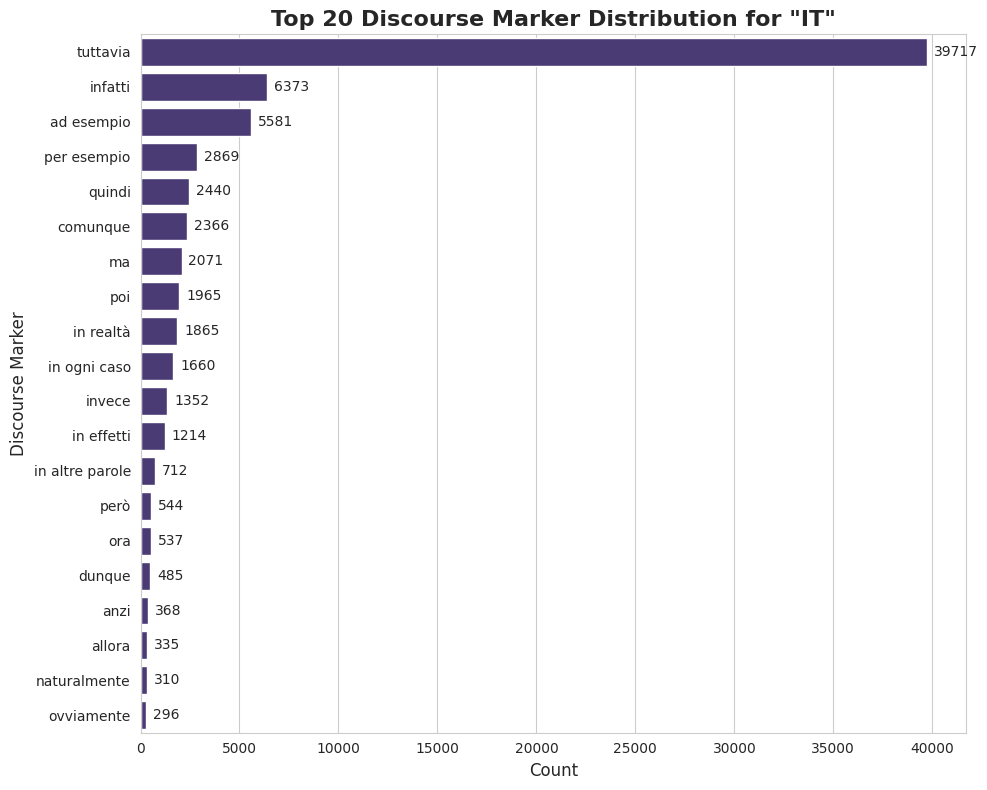

----------------------------------------

--- Analyzing Language: PT ---
Total instances found: 181,890
Total unique markers found: 57


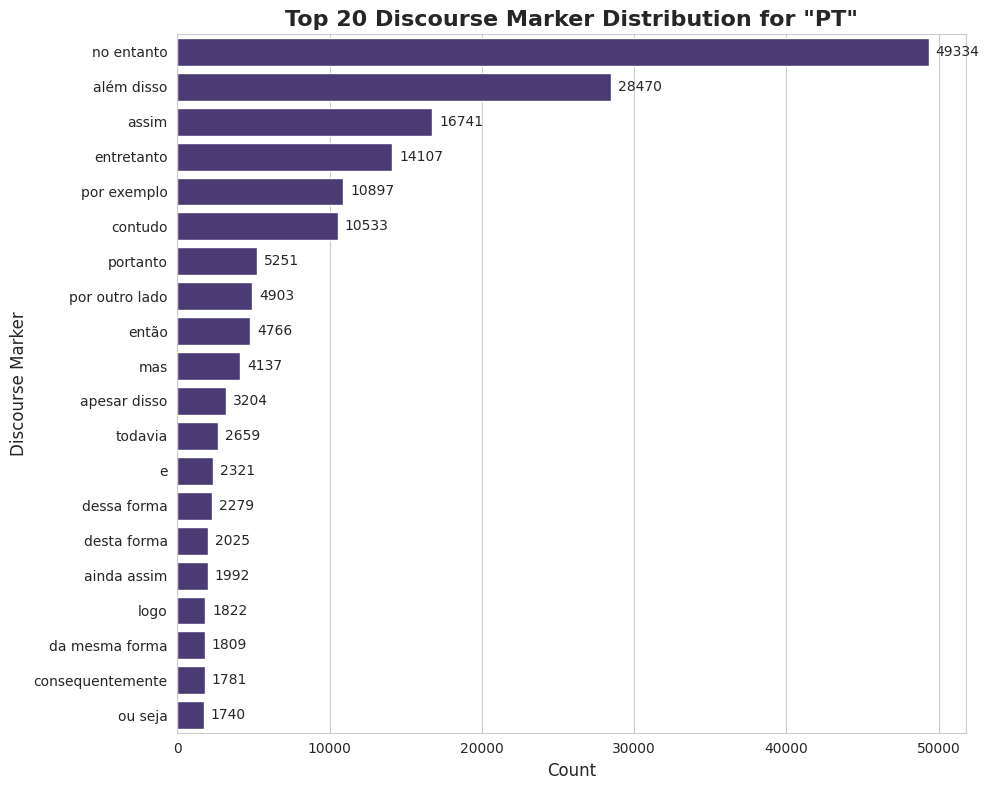

----------------------------------------



In [2]:
# Make sure plots are displayed inline in the notebook
%matplotlib inline

# --- Configuration ---

# List the languages you have processed (e.g., ['en', 'it', 'pt'])
LANGUAGES_TO_ANALYZE = ['en', 'it', 'pt']

BASE_OUTPUT_DIR = "results"
DATA_FILE_NAME = "mined_data.jsonl"
TOP_N_MARKERS = 20  # Number of top markers to display in the chart

# --- Set Seaborn Style ---
sns.set_style("whitegrid")
sns.set_palette("viridis") # You can change this palette

# --- Analysis Loop ---

for lang in LANGUAGES_TO_ANALYZE:
    print(f"--- Analyzing Language: {lang.upper()} ---")
    
    file_path = os.path.join(BASE_OUTPUT_DIR, lang, DATA_FILE_NAME)
    
    # 1. Check if the dataset file exists
    if not os.path.exists(file_path):
        print(f"Dataset file not found at: {file_path}")
        print("Please run the mining script for this language first.")
        print("-" * 40 + "\n")
        continue
        
    # 2. Read the .jsonl file into a list of dictionaries
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                print(f"Warning: Skipping a corrupted line in {file_path}")

    # 3. Check if data was actually loaded
    if not data:
        print(f"Dataset file at {file_path} is empty.")
        print("-" * 40 + "\n")
        continue

    # 4. Convert to a Pandas DataFrame for easy analysis
    df = pd.DataFrame(data)
    
    # 5. Show the total size
    print(f"Total instances found: {len(df):,}")
    
    # 6. Get the distribution of discourse markers
    dm_counts = df['dm_label'].value_counts()
    
    # 7. Prepare data for plotting (Top N)
    dm_counts_top = dm_counts.head(TOP_N_MARKERS).reset_index()
    dm_counts_top.columns = ['Discourse Marker', 'Count']
    
    print(f"Total unique markers found: {len(dm_counts)}")
    
    # 8. Plot the distribution
    plt.figure(figsize=(10, 8))  # Set figure size (width, height)
    
    ax = sns.barplot(
        data=dm_counts_top, 
        x='Count', 
        y='Discourse Marker'
    )
    
    # Set plot titles and labels (in English)
    ax.set_title(
        f'Top {TOP_N_MARKERS} Discourse Marker Distribution for "{lang.upper()}"', 
        fontsize=16, 
        fontweight='bold'
    )
    ax.set_xlabel('Count', fontsize=12)
    ax.set_ylabel('Discourse Marker', fontsize=12)
    
    # Add count labels to the end of each bar
    ax.bar_label(ax.containers[0], fmt='%d', padding=5)
    
    # Adjust layout to prevent labels from being cut off
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    print("-" * 40 + "\n")

# Sentiment Analysis

## Imports

In [2]:
import pandas as pd
import numpy as np
import spacy
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from tqdm import tqdm

## Functions and Setup

In [3]:
tqdm.pandas()

def load_discourse_markers(filepath):
    """
    Loads DMs from a text file, sorted from longest to shortest.
    """
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            markers = [line.strip() for line in f if line.strip()]
        markers.sort(key=len, reverse=True)
        print(f"Loaded {len(markers)} discourse markers from '{filepath}'.")
        return markers
    except FileNotFoundError:
        print(f"Error: Marker file '{filepath}' not found.")
        print("Please provide the correct path to your discourse markers text file.")
        return None

def is_valid_sentence(text, min_words=1):
    """
    A placeholder for your is_valid_sentence function.
    This version checks for a minimum word count, as implied by your code.
    """
    return len(text.split()) >= min_words

In [5]:
try:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner", "lemmatizer"])
    nlp.add_pipe("sentencizer")
    nlp.max_length = 2000000
    print("Spacy model 'en_core_web_sm' loaded successfully.")
except OSError:
    print("Error: Spacy model 'en_core_web_sm' not found.")
    print("Please make sure it's installed (run: python -m spacy download en_core_web_sm)")

Spacy model 'en_core_web_sm' loaded successfully.


In [8]:
discourse_markers = load_discourse_markers('dm/en.txt')

Loaded 173 discourse markers from 'dm/en.txt'.


In [10]:
try:
    df = pd.read_csv('experiment_results.csv')
    print("Loaded 'imdb_experiment_results.csv' successfully.")
    print(df.info())
    print(df.head())
except FileNotFoundError:
    print("Error: 'imdb_experiment_results.csv' not found.")
    print("Please make sure the file is in the correct directory.")

Loaded 'imdb_experiment_results.csv' successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         20000 non-null  object
 1   label        20000 non-null  int64 
 2   case_1_pred  20000 non-null  int64 
 3   case_2_pred  20000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 625.1+ KB
None
                                                text  label  case_1_pred  \
0  I found it real shocking at first to see Willi...      1            1   
1  it's a great movie for the whole family. i don...      1            1   
2  This movie is not a remake of She's all That (...      0            0   
3  Believe me I wanted this series to work, but t...      1            0   
4  It's not a movie, but an experience!<br /><br ...      1            1   

   case_2_pred  
0            1  
1            1  
2            0  
3            

## Plots


Generating confusion matrices...
Saved confusion matrices to 'confusion_matrices.png'


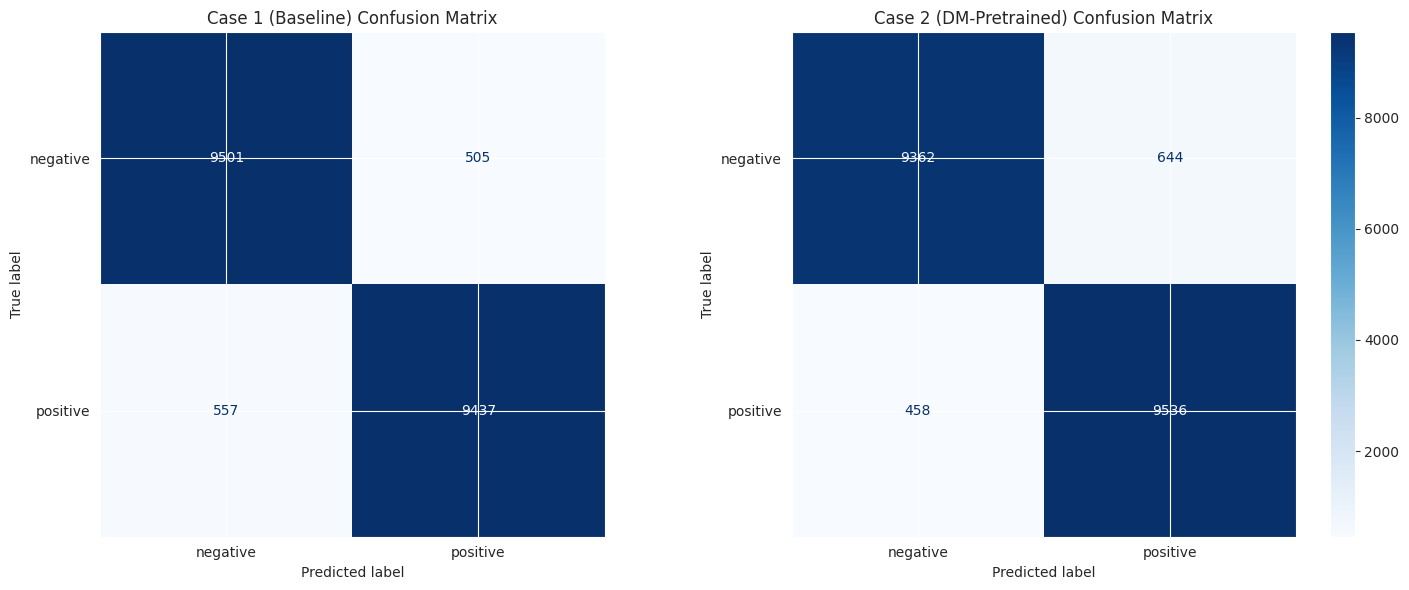

In [11]:
print("\nGenerating confusion matrices...")
sentiment_class_names = ['negative', 'positive'] # Assuming 0: neg, 1: pos

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Case 1 Heatmap
cm1 = confusion_matrix(df['label'], df['case_1_pred'])
disp1 = ConfusionMatrixDisplay(cm1, display_labels=sentiment_class_names)
disp1.plot(ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
axes[0].set_title('Case 1 (Baseline) Confusion Matrix')

# Case 2 Heatmap
cm2 = confusion_matrix(df['label'], df['case_2_pred'])
disp2 = ConfusionMatrixDisplay(cm2, display_labels=sentiment_class_names)
disp2.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=True)
axes[1].set_title('Case 2 (DM-Pretrained) Confusion Matrix')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
print("Saved confusion matrices to 'confusion_matrices.png'")
plt.show()

# Has Discourse Markers

In [14]:
def check_for_dm(text):
    if not isinstance(text, str):
        return False

    doc = nlp(text)
    sentences = list(doc.sents)

    if len(sentences) < 2:
        return False

    for i in range(1, len(sentences)):
        s1_span = sentences[i-1]
        s2_span = sentences[i]

        s2_text_lower_stripped = s2_span.text.lower().strip()

        for dm in discourse_markers:
            if s2_text_lower_stripped.startswith(dm):

                rest_of_s2 = s2_text_lower_stripped[len(dm):].strip()
                if rest_of_s2.startswith(','):

                    s1_text = s1_span.text.strip()
                    s2_text = s2_span.text.strip() # The original text, not lowercased

                    # Using our placeholder is_valid_sentence
                    if s1_text.endswith(('.', ';', '!', '?')) and \
                       is_valid_sentence(s1_text) and \
                       is_valid_sentence(s2_text, len(dm.split()) + 3):

                        # Found a DM that matches all criteria
                        return True

                    # This s2 starts with this DM, but didn't pass
                    # the other checks. Break to the next s2.
                    break

    # No DM was found in any s2 that matched all criteria
    return False

In [15]:
df['has_dm'] = df['text'].progress_apply(check_for_dm)

print("DM analysis complete.")
print(df['has_dm'].value_counts())

100%|██████████| 20000/20000 [08:17<00:00, 40.22it/s]

DM analysis complete.
has_dm
False    14896
True      5104
Name: count, dtype: int64


In [16]:
print("\n--- Comparative Accuracy Analysis ---")

# Overall Accuracy
acc_case_1_overall = accuracy_score(df['label'], df['case_1_pred'])
acc_case_2_overall = accuracy_score(df['label'], df['case_2_pred'])

print(f"Overall Accuracy (n={len(df)}):")
print(f"  Case 1 (Baseline): {acc_case_1_overall:.4f}")
print(f"  Case 2 (DM-Pre):   {acc_case_2_overall:.4f}")


--- Comparative Accuracy Analysis ---
Overall Accuracy (n=20000):
  Case 1 (Baseline): 0.9469
  Case 2 (DM-Pre):   0.9449


In [17]:
# Subset: HAS Discourse Marker
df_with_dm = df[df['has_dm'] == True]
if not df_with_dm.empty:
    acc_case_1_with_dm = accuracy_score(df_with_dm['label'], df_with_dm['case_1_pred'])
    acc_case_2_with_dm = accuracy_score(df_with_dm['label'], df_with_dm['case_2_pred'])

    print(f"\nAccuracy on texts WITH DM (n={len(df_with_dm)}):")
    print(f"  Case 1 (Baseline): {acc_case_1_with_dm:.4f}")
    print(f"  Case 2 (DM-Pre):   {acc_case_2_with_dm:.4f}")
else:
    print("\nNo texts with DMs (matching your criteria) were found.")

# Subset: does NOT have Discourse Marker
df_without_dm = df[df['has_dm'] == False]
if not df_without_dm.empty:
    acc_case_1_without_dm = accuracy_score(df_without_dm['label'], df_without_dm['case_1_pred'])
    acc_case_2_without_dm = accuracy_score(df_without_dm['label'], df_without_dm['case_2_pred'])

    print(f"\nAccuracy on texts WITHOUT DM (n={len(df_without_dm)}):")
    print(f"  Case 1 (Baseline): {acc_case_1_without_dm:.4f}")
    print(f"  Case 2 (DM-Pre):   {acc_case_2_without_dm:.4f}")
else:
    print("\nNo texts without DMs were found.")

print("\nAnalysis complete.")


Accuracy on texts WITH DM (n=5104):
  Case 1 (Baseline): 0.9342
  Case 2 (DM-Pre):   0.9359

Accuracy on texts WITHOUT DM (n=14896):
  Case 1 (Baseline): 0.9513
  Case 2 (DM-Pre):   0.9480

Analysis complete.
